<a href="https://colab.research.google.com/github/suzzini/DS_Project/blob/main/n221a_decision_trees_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 1*

# 📝 Assignment
---

# Decision Trees(결정트리)

## 캐글 인클래스(InClass) Competitions

### 1) EDA를 수행합시다

- [캐글 계정을 만드세요](https://www.kaggle.com/), 공유된 인클래스 대회 url을 통해 이동한 후 대회에 참여하세요.
- H1N1 데이터를 훈련/검증/테스트 셋으로 나누어 준비하세요
- profiling을 사용하여 데이터를 살펴보고, missing value, zeros, cardinarity 등을 확인하여 처리하세요.
- 본인만의 특성공학을 수행하세요.
- **(객관식) H1N1 분류기의 기준모델을 설정하세요. 기준모델의 정확도를 과제 제출폼에 제출하세요.**
    1. 0.24
    2. 0.50
    3. 0.76
    4. 1


In [ ]:
### 이곳에서 과제를 진행해 주세요 ### eda 해야함
import pandas as pd

target = 'vacc_h1n1_f' #독감
# target = 'vacc_seas_f' #계절독감
train=pd.merge(pd.read_csv('train.csv'),pd.read_csv('train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('submission.csv')
#train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
 #                pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
#test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
#sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')


In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)


train.shape, val.shape, test.shape

((33723, 39), (8431, 39), (28104, 38))

In [ ]:
from sklearn.metrics import accuracy_score
baseline = [y_train.mode()[0]] * len(y_train)
print(f"Accuracy of the baseline: {accuracy_score(y_train, baseline):.3f}")

Accuracy of the baseline: 0.761


Text(0.5, 1.0, 'Total Missing Value (%)')

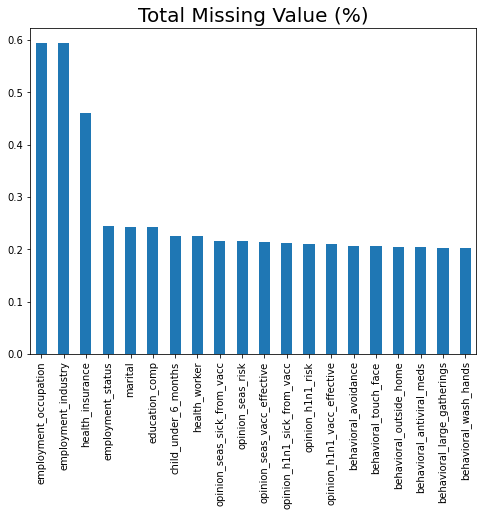

In [ ]:
import matplotlib.pyplot as plt


total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value (%)", fontsize = 20)

In [ ]:
train.corr()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_insurance,health_worker,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,census_region,n_adult_r,household_children,n_people_r,hhs_region,vacc_h1n1_f
h1n1_concern,1.000000,0.068498,0.103078,0.224592,0.142365,0.298185,0.252830,0.244025,0.249066,0.141031,0.131992,0.100199,0.038141,-0.010939,0.030970,-0.065259,-0.084590,0.122892,0.024834,-0.023765,-0.009142,-0.013733,-0.004623,0.045210,0.029278,-0.047558,0.118460
h1n1_knowledge,0.068498,1.000000,-0.004052,0.088954,0.022416,0.084557,-0.041014,-0.061258,0.081216,0.100326,0.067627,-0.025682,0.026714,0.122419,0.167445,0.312275,0.095957,0.067179,-0.212638,-0.128944,-0.005413,-0.023904,0.039662,0.062558,0.063656,-0.010361,0.118043
behavioral_antiviral_meds,0.103078,-0.004052,1.000000,0.054692,0.144103,0.073772,0.120541,0.134867,0.083031,0.047072,0.034168,0.000076,0.022526,-0.057584,0.006909,-0.073200,-0.113678,0.008222,0.051908,0.014888,-0.008376,0.020228,0.051716,0.090959,0.095287,0.001056,0.045101
behavioral_avoidance,0.224592,0.088954,0.054692,1.000000,0.065585,0.330083,0.225084,0.222855,0.330099,0.072875,0.077731,0.034730,-0.002612,0.024961,-0.004708,0.017535,-0.007007,0.113297,-0.052374,-0.056557,-0.008527,-0.003198,0.024214,0.039454,0.040509,-0.014397,0.036801
behavioral_face_mask,0.142365,0.022416,0.144103,0.065585,1.000000,0.080567,0.165296,0.159710,0.100465,0.074211,0.068610,0.061349,0.037856,-0.034360,0.063011,-0.058560,-0.052613,0.045133,0.051128,0.011706,0.008287,0.029649,0.010171,0.023150,0.022745,0.013878,0.075515
behavioral_wash_hands,0.298185,0.084557,0.073772,0.330083,0.080567,1.000000,0.193376,0.193158,0.368231,0.084779,0.099341,0.023595,0.032983,0.020013,0.040191,-0.026428,-0.052399,0.151378,-0.015125,-0.047058,-0.009704,-0.011343,0.025229,0.052197,0.051409,-0.027637,0.071035
behavioral_large_gatherings,0.252830,-0.041014,0.120541,0.225084,0.165296,0.193376,1.000000,0.591175,0.256721,0.073321,0.090923,0.100276,0.025132,-0.052772,-0.035219,-0.174899,-0.067705,0.058910,0.104360,0.026658,-0.002167,0.016895,-0.023557,-0.000545,-0.012658,-0.009686,0.018546
behavioral_outside_home,0.244025,-0.061258,0.134867,0.222855,0.159710,0.193158,0.591175,1.000000,0.274869,0.068730,0.082733,0.092945,0.018257,-0.064032,-0.033093,-0.193469,-0.083290,0.050513,0.126178,0.034571,-0.000591,0.017118,-0.023912,-0.003282,-0.015671,-0.008871,0.016090
behavioral_touch_face,0.249066,0.081216,0.083031,0.330099,0.100465,0.368231,0.256721,0.274869,1.000000,0.085306,0.106752,0.034960,0.031633,-0.002347,0.068271,-0.063770,-0.044167,0.170292,0.020007,-0.032499,-0.005764,-0.004327,0.005459,0.031618,0.025375,-0.022123,0.058798
doctor_recc_h1n1,0.141031,0.100326,0.047072,0.072875,0.074211,0.084779,0.073321,0.068730,0.085306,1.000000,0.611772,0.119408,0.072066,0.067677,0.109383,0.029176,-0.012617,0.021085,-0.049702,-0.022445,-0.010329,-0.038035,0.017408,0.092121,0.077823,-0.035044,0.400660


In [ ]:
import numpy as np

def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # 결측치가 많은 특성을 제거합니다.
    # 이대로 하면 안됨, state가 중요할 수도 
    selected_cols = df.select_dtypes(include=['number', 'object'])
    missing = selected_cols.isnull().sum() # 결측치 수
    selected_features = missing[missing <= len(df)/2].index.tolist() # 결측치가 50% 이하만 추출
    df = df[selected_features]
  


    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    #df.drop(columns=behaviorals,inplace=True) #새로만들어진 특성을 제외하고 drop #하니까 더 떨어짐;
    
    #무작정 따라하면 안됨, 계절 독감 특성이 중요할 수도 !
    dels = [col for col in df.columns if ('employment' in col or 'seas' in col)] 
    df.drop(columns=dels, inplace=True)
    
    df.drop(columns=['sex_i','raceeth4_i','hhs_region'] ,inplace=True)

    df['rent_own_r']=df['rent_own_r'].replace(99, np.NaN).replace(77, np.NaN)

    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [ ]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

### 2) 모델 개발
- 결정트리를 학습시킵니다. 하이퍼파라미터를 수정하여 성능을 높여보세요. 과적합을 주의하세요!
- 검증세트 스코어를 확인하세요.(평가지표는 F1-score입니다, 수식은 캐글 Overview-Evaluation 페이지를 확인해 주세요. 평가지표에 대한 내용은 다음에 자세히 배우고 활용할 것입니다 지금은 스코어를 올리기 위한 노력을 전혀 기울이지 말고 결정트리의 개념과 코드이해, 사용에 집중하세요!)
- 특성중요도를 그래프로 나타내 보세요
- **검증세트의 F1-score를 과제 제출폼에 제출하세요. (0.5 이상 통과)**

In [ ]:
pip install category-encoders

     |████████████████████████████████| 81kB 4.9MB/s 


In [ ]:
### 이곳에서 과제를 진행해 주세요 ###

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from ipywidgets import interact

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=2, criterion='entropy',min_samples_split=100,min_samples_leaf=100) #best 파라미터를 쓰면 모든 경우의 수를 계산해게 됨
    #entropy 디폴트는 지니 
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))

pipe.predict(X_val)



/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도:  0.8270023426148326
검증 정확도:  0.8287273158581425


array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
f1_score(pipe.predict(X_val), y_val)

0.5757931844888365

### 3) 캐글 대회 참여

- 테스트셋에 대한 예측 결과를 캐글에 제출 하세요.(스코어가 많이 낮게 나와도 결정트리를 잘 이해하고 결과를 내었다면 충분합니다!)
- **캐글 Leaderboard의 본인 Score를 과제 제출폼에 제출하세요.**
 

In [ ]:
y_test_pred = pipe.predict(X_test)

In [ ]:
sample_submission['vacc_h1n1_f'] = y_test_pred

sample_submission.to_csv('submission_test5.csv', index=False)

## 🔥 도전과제

### 4) 다른 종류의 imputer를 사용하고 특성-타겟 관계 그래프를 나타내 보세요.
- 다른 종류의 imputer를 사용해 보세요([scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html))
- seaborn plots 사용하여 관심있는 특성들과 target간의 관계를 그래프로 나타내 보세요.
- [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html)
- [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html)

In [ ]:
### 이곳에서 과제를 진행해 주세요 ###